<a href="https://colab.research.google.com/github/TomasMendozaHN/ICDF_Class/blob/main/30032022_Cats_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
pip install kaggle

In [ ]:
!mkdir ~/.kaggle #mkdir = make directory
!cp kaggle.json ~/.kaggle/  # cp = copy
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download dogs-vs-cats

In [ ]:
! unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!dir

dogs-vs-cats.zip  sample_data		test1.zip
kaggle.json	  sampleSubmission.csv	train.zip


In [ ]:
!unzip train.zip

In [ ]:
!unzip test1.zip

In [ ]:
!dir

dogs-vs-cats.zip  sample_data		test1	   train
kaggle.json	  sampleSubmission.csv	test1.zip  train.zip


In [ ]:
# Train path
trainPth = "train"
testPth = "test1"

In [ ]:
import os
for file in os.listdir(testPth):
  print(file)
  break

6972.jpg


In [ ]:
import glob
file_list = glob.glob(trainPth + "/*.jpg")
for fname in file_list:
  category = fname.split("/")[1].split(".")[0]
  print(category)
  break

cat


In [ ]:
# Create DataLoader
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from PIL import Image

class CatsVsDogs(Dataset):

  def __init__(self, root_dir, transform=None):
      self.data = []
      file_list = glob.glob(root_dir + "/*.jpg")
      for fname in file_list:
          category = fname.split("/")[1].split(".")[0]
          self.data.append([fname, category])
      self.class_map = {"cat" : 0, "dog": 1}

  def __len__(self):
      return len(self.data) 

  def __getitem__(self, idx):
    fname, category = self.data[idx]
    img = Image.open(fname).resize((80,80))
    img = np.array(img)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img)
    label = self.class_map[category]
    label = torch.tensor(label)
    return img, label

In [ ]:
trainDL = CatsVsDogs(trainPth)
trainDL = DataLoader(trainDL, batch_size=256, shuffle=True)

testDL = CatsVsDogs(testPth)
testDL = DataLoader(testDL, batch_size=256, shuffle=True)

# Define your network

In [ ]:
from torch.nn import Module
from torch.nn import Conv2d, Linear, MaxPool2d, ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn

class Classifier(nn.Module):
  def __init__(self, numChannels, classes):
		# call the parent constructor
    super(Classifier, self).__init__()

    # initialize first set of CONV => RELU => POOL layers
    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
      kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    self.conv2 = Conv2d(in_channels=20, out_channels=50,
      kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = Linear(in_features=14450, out_features=500)
    self.relu3 = ReLU()

    # initialize our softmax classifier
    self.fc2 = Linear(in_features=500, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)
  

  def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
  
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
  
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    # pass the output to our softmax classifier to get our output
    # predictions
    x = self.fc2(x)
    output = self.logSoftmax(x)

    # return the output predictions
    return output

In [ ]:
from torch.optim import Adam

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = Classifier(numChannels=3, classes=2)
CNN.to(device)

Classifier(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14450, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

#Hyperparameters

In [ ]:
# initialize our optimizer and loss function
opt = Adam(CNN.parameters(), lr=0.0001)
lossFn = nn.NLLLoss()

In [ ]:
EPOCHS = 1

# TRAIN!

  0%|          | 0/98 [00:00<?, ?it/s]

Finished epoch = 0 with Accuracy = 82.66799999999999 and Loss = 0.0015289266324043274


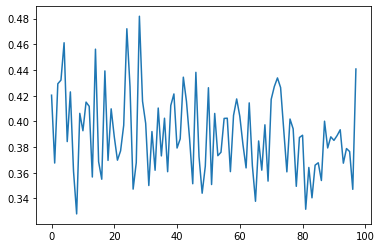

In [ ]:
from tqdm.notebook import tqdm
historical_loss = []
# loop over our epochs
for e in range(0, EPOCHS):
  # set the model in training mode
  CNN.train()
  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalValLoss = 0
  # initialize the number of correct predictions in the training
  # and validation step
  trainCorrect = 0
  valCorrect = 0
  # loop over the training set
  for (x, y) in tqdm(trainDL):

    # send the input to the device
    x = x.type(torch.FloatTensor)
    (x, y) = (x.to(device), y.to(device))
    
    # perform a forward pass and calculate the training loss
    pred = CNN(x)
    loss = lossFn(pred, y)
    # zero out the gradients, perform the backpropagation step,
    # and update the weights
    opt.zero_grad()
    loss.backward()
    opt.step()
    # add the loss to the total training loss so far and
    # calculate the number of correct predictions
    totalTrainLoss += loss.detach().cpu().numpy()
    historical_loss.append(loss.detach().cpu().numpy())
    trainCorrect += (pred.argmax(1) == y).type(
      torch.float).sum().item()

  # calculate the average training and validation loss
  avgTrainLoss = totalTrainLoss / len(trainDL.dataset)

  # calculate the training and validation accuracy
  trainCorrect = (trainCorrect / len(trainDL.dataset)*100)

  print(f"Finished epoch = {e} with Accuracy = {trainCorrect} and Loss = {avgTrainLoss}")
  plt.plot(historical_loss)
  plt.show()

# TEST!

In [ ]:
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	CNN.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDL:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = CNN(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
  
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

KeyError: ignored